# What's happening here?

This is a playground notebook for testing different ways to manipulate images. This can be used to further augment the limited pool of training data that was scraped from the web.


Feel free to investigate, experiment and improve!

# Start coding

## Import modules

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Create some folders
Let's create a few folders in case they aren't there yet.

* `src-img` source images folder.
* `dest-img` image destination folder.

In [2]:
!mkdir -p src-img
!mkdir -p dest-img

## Populate the `src-img` folder with images

## Read image file paths

In [3]:
src_img_dir = os.path.join('src-img')
src_img_list = os.listdir(src_img_dir)
# Get directory contents
src_img_paths = [os.path.join(src_img_dir, x) for x in src_img_list]
# discard images
src_img_paths = sorted([x for x in src_img_paths if not os.path.isdir(x)])
src_img_paths

['src-img/black.jpg',
 'src-img/blue.jpg',
 'src-img/cyan.jpg',
 'src-img/green.jpg',
 'src-img/grey.jpg',
 'src-img/half_black.jpeg',
 'src-img/img_00000.jpeg',
 'src-img/img_00001.jpeg',
 'src-img/img_00002.jpeg',
 'src-img/img_00003.jpeg',
 'src-img/img_00004.jpeg',
 'src-img/img_00005.jpeg',
 'src-img/img_00006.jpeg',
 'src-img/img_00007.jpeg',
 'src-img/img_00008.jpeg',
 'src-img/img_00009.jpeg',
 'src-img/img_00010.jpeg',
 'src-img/img_00011.jpeg',
 'src-img/img_00012.jpeg',
 'src-img/img_00013.jpeg',
 'src-img/magenta.jpg',
 'src-img/red.jpg',
 'src-img/white.jpg',
 'src-img/yellow.jpg']

## Function definitions

### Base image manipulation functions

In [13]:
def read_image(image_path):
    """Load an image from it's path and return an image object"""
    return cv2.imread(image_path)

def rotate_image(img, angle):
    """Rotate an image by a certain angle"""
    h, w = img.shape[:2]
    
    # Define rotation center (center of image)
    c_x, c_y = w/2, h/2
    # Define rotation matrix with X degrees of rotation
    rotation_matrix = cv2.getRotationMatrix2D((c_x, c_y), angle, 1.0)

    # Rotate the image
    rotated = cv2.warpAffine(img, rotation_matrix, (w, h))
    return rotated

def rotate_image_fixed_angles(img):
    """Rotate an image by 90, 180 and 270 degrees.
    Returns a list of the rotated images and a list of angles."""
    rotated_images = []
    angles = []
    
    # rotate 90
    img_90 = cv2.transpose(img)
    img_90 = cv2.flip(img_90, 1)
    rotated_images.append(img_90)
    angles.append(90)

    # rotate 180
    img_180 = cv2.flip(img, -1)
    rotated_images.append(img_180)
    angles.append(180)

    # rotate 270
    img_270 = cv2.transpose(img)
    img_270 = cv2.flip(img_270, 0)
    rotated_images.append(img_270)
    angles.append(270)
    
    return rotated_images, angles

def scale_image(img, factor, interpolation):
    """Scale an image"""
    h, w = img.shape[:2]
    return cv2.resize(img, (int(w*factor), int(h*factor)), interpolation)

def crop_image(img, x1, x2, y1, y2):
    """Crop an image.
    Provide X and Y bounds.
    y2 > y1 and x2 > x1."""
    return img[int(y1):int(y2), int(x1):int(x2)]

def is_mostly_black(img, color_threshold, blackness):
    """Detect if image is mostly black.
    
    img: 
        Image object.
        
    color_threshold: 0-255
        Everything below this value is considered black.
        
    blackness: 0.0-1.0
        Ratio between black and bright pixels. 
        An image is considered black if it's ratio of black pixels 
        is above the defined blackness value.
        
    """
    # Set all color values below threshold to "True" and the rest to "False"
    binary_img = (img <= color_threshold)
    # Reshape the image so it's basically one long line of lists. We remove one dimension.
    reshaped = np.reshape(binary_img, (binary_img.shape[0] * binary_img.shape[1], 3))
    
    # Now check which array elements are pure black
    blacks = np.all(reshaped, axis=1)
    
    # Calculate image dimensions
    num_values = blacks.shape[0]
    non_zero = blacks[blacks[:] == False].shape[0]
    zero_values = blacks[blacks[:] == True].shape[0]
    
    # Finally return if the image is mostly black
    return zero_values > num_values * blackness

### Save image function

In [14]:
def save_image(img, filepath, colorspace):
    """Save an image object to the harddrive"""
    plt.imsave(filepath, cv2.cvtColor(img, colorspace))

## Functions demo

### Read source images, rotate them in 90 degree increments, save to disc

In [29]:
# Save rotated images here
destination_folder = os.path.join('dest-img')
target_colorspace = cv2.COLOR_BGR2RGB

# Read each image from it's path
for src_img in src_img_paths:
    img = read_image(src_img)
    # Rotate images in 90 degree increments
    rotated_imgs = rotate_image_fixed_angles(img)
    
    # Save rotated images to destination folder on disc
    for i, rot_img in enumerate(rotated_imgs[0]):
        split = os.path.splitext(os.path.basename(src_img))
        basename = split[0]
        ext = split[1]
        angle = rotated_imgs[1][i]
        save_image(rot_img, os.path.join(destination_folder, f'{basename}_{angle}{ext}'), target_colorspace)
    
    # Copy original image to destination folder
    save_image(img, os.path.join(destination_folder, f'{basename}{ext}'), target_colorspace)

### Load an image, rotate it and zoom in

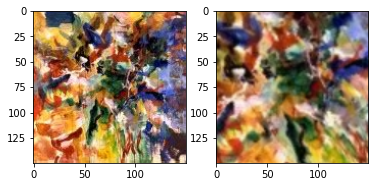

In [18]:
# Read the image
img = read_image(src_img_paths[10])
# Store original image dimensions
h, w = img.shape[:2]
# Rotate the image
img_obj = rotate_image(img, 30)
# Scale the image
img_obj = scale_image(img_obj, 1.5, cv2.INTER_CUBIC)
# Store transformed image dimensions
r_h, r_w = img_obj.shape[:2]

# Calculate crop region
y1 = (r_h/2)-(h/2)
y2 = (r_h/2)+(h/2)
x1 = (r_w/2)-(w/2)
x2 = (r_w/2)+(w/2)

# Crop the image
img_obj = crop_image(img_obj, x1, x2, y1, y2)

# Show the result
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_obj, cv2.COLOR_BGR2RGB))


### Random rotate and zoom the source images, save to disc

In [45]:
import random

# src_img_paths
for i in range(31):
    for src_img in src_img_paths:
        # Read the image
        img_obj = read_image(src_img)
        # Store original image dimensions
        h, w = img_obj.shape[:2]


        # Prepare random rotation by getting a random angle
        randrotate = random.randrange(1,359)

        # Check if random angle is too close to 90, 180, 270 and 360 degrees.
        # If it is, regenerate random number.
        while not \
        (randrotate > 10 and randrotate < 80 or \
        randrotate > 100 and randrotate < 170 or \
        randrotate > 190 and randrotate < 260 or \
        randrotate > 280 and randrotate < 350):
            randrotate = random.randrange(1,359)


        # Rotate the image randomly
        img_obj = rotate_image(img_obj, randrotate)
        # Scale the image randomly
        randscale = random.uniform(0.7, 3)
        img_obj = scale_image(img_obj, randscale, cv2.INTER_CUBIC)

        # Store transformed image dimensions
        r_h, r_w = img_obj.shape[:2]

        # Calculate crop region
        y1 = (r_h/2)-(h/2)
        y2 = (r_h/2)+(h/2)
        x1 = (r_w/2)-(w/2)
        x2 = (r_w/2)+(w/2)

        # Crop the image
        img_obj = crop_image(img_obj, x1, x2, y1, y2)

        split = os.path.splitext(os.path.basename(src_img))
        basename = split[0]
        ext = split[1]
        save_image(img_obj, os.path.join('dest-img', f'{basename}_{randrotate}{ext}'), cv2.COLOR_BGR2RGB)

### Black image detection test on output images

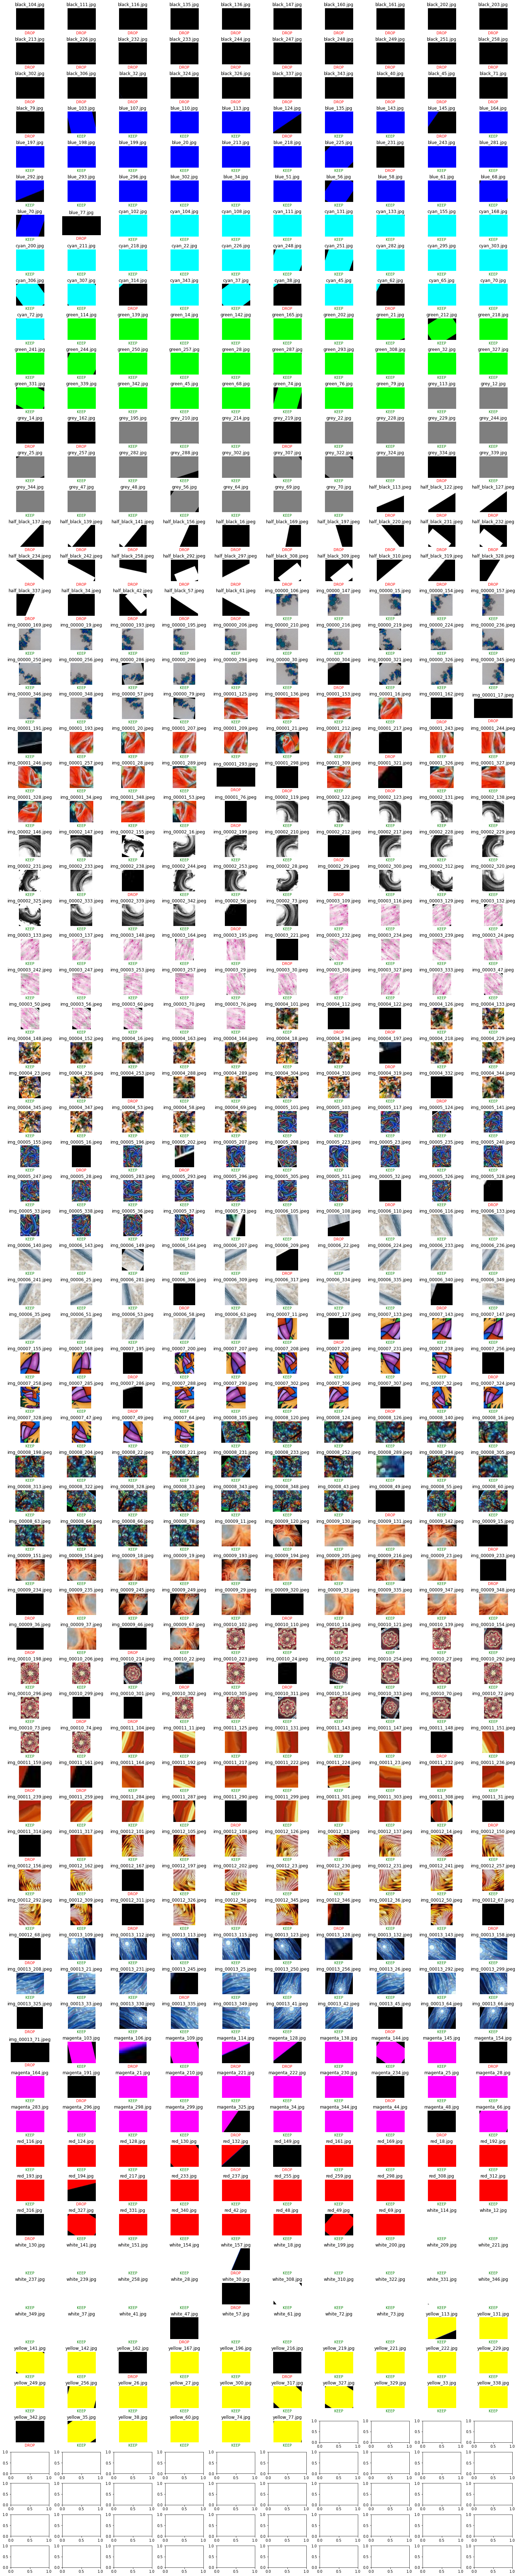

In [44]:
# This can take a few minutes depending on how many images there are.
# Runs in around 1:30 Minutes with 700 tiny images

check_images_dir = os.path.join('dest-img')
# Get directory contents
check_images = os.listdir(check_images_dir)
check_images = sorted([os.path.join(check_images_dir, x) for x in check_images])

if len(check_images) > 0:
    rows = 75
    cols = 10
    img_count = 0
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,100), constrained_layout=True)

    for i in range(rows):
        for j in range(cols):
            if img_count < len(check_images):
                img = read_image(check_images[img_count])
                axes[i, j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                
                # Hide ticks and outside borders
                axes[i, j].set_xticks([])
                axes[i, j].set_yticks([])
                axes[i, j].spines.left.set_visible(False)
                axes[i, j].spines.right.set_visible(False)
                axes[i, j].spines.top.set_visible(False)
                axes[i, j].spines.bottom.set_visible(False)
                
                # Filename as image titles
                axes[i, j].set_title(os.path.basename(check_images[img_count]))
                
                # Detect if image is mostly black
                isblack = is_mostly_black(img, 15, .4)
                                
                # Set image subtitles and colors based on the black detection
                action = 'DROP' if isblack else 'KEEP'
                color = 'red' if isblack else 'green'
                axes[i, j].xaxis.label.set_color(color)
                axes[i, j].set_xlabel(f'{action}')
                
                img_count += 1